In [1]:
import os
import sys

import clip

import torch 
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms

from PIL import Image

module_path = os.path.join(os.getcwd(), '../src')
sys.path.append(module_path)

from gan_t2i.models.GAN_INT_CLS import GAN_INT_CLS
from gan_t2i.datasets.DatasetFactory import DatasetFactory
from gan_t2i.models.CLIP import CLIPModel
from gan_t2i.utils.model_loading import download_CLIP_model, CLIP_DATASETS

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Images transformations
transform_img = transforms.Compose([
    transforms.Resize(64, interpolation=Image.BICUBIC),
    transforms.CenterCrop(64),
    transforms.ToTensor(),    
    transforms.Normalize([0.4355, 0.3777, 0.2879], [0.2571, 0.2028, 0.2101])
])

# Text transformation (caption tokenizer)
def tokenize_text(text):
    try:
        return clip.tokenize([text])[0]
    except:
        return clip.tokenize([text.split(".")[0]])[0] 

In [3]:
# Load data
data_path = os.path.join(os.getcwd(), "..", "data") 
dataset = DatasetFactory.Flowers(data_path, transform_img=transform_img, transform_caption=tokenize_text)

Captions already downloaded
images already downloaded
Captions already extracted
images already extracted
The dataset is already stored in HDF5 format


In [4]:
# Split data into train, validation and test
train_size = int(0.05 * len(dataset))       
val_size = int(0.02 * len(dataset))
test_size = int(0.02 * len(dataset))

# Cration of train, validation and test set indices and samplers
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, train_size + val_size + test_size))

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Creation of train, validation and test dataloaders
train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler, pin_memory=True)
test_loader = DataLoader(dataset, batch_size=64, sampler=test_sampler, pin_memory=True)

In [5]:
# Get the caption embedding network (our finetuned version of CLIP)
checkpoint_path = download_CLIP_model(CLIP_DATASETS.FLOWERS)
clip_emb_model = CLIPModel.load(checkpoint_path)

CLIP model FLOWERS already exits at c:\Users\Alex\Documents\GitHub\Deep-Learning-Final-Project\examples\models_weights\CLIP\CLIP~FT_FLOWERS\CLIP~FT_FLOWERS.pt
Model loaded on device: cuda


In [7]:
# Create the GAN-INT-CLS model
gan = GAN_INT_CLS(
    emb_network=clip_emb_model,
    emb_dim=512
)

gan.fit(train_loader, val_loader, num_epochs=3)

  0%|          | 0/64 [00:00<?, ?it/s]c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch [1/3] Batch [64/64]: Loss: 1.572239 |Real Acc.: 0.552766 |Fake Acc.: 0.995361 |Wrong Acc.: 0.551096: 100%|██████████| 64/64 [00:10<00:00,  5.94it/s]
Validation => Val Loss: 1.949804 | Real Acc.: 0.293221 | Fake Acc.: 0.934057 | Wrong Acc.: 0.738192: 100%|██████████| 26/26 [00:03<00:00,  7.45it/s]


Epoch [1/3] Summary:
  - Train
    => Total Loss: 1.572239
    => Real Acc: 0.552766
    => Fake Acc: 0.995361
    => Wrong Acc: 0.551096
  - Validation
    => Val Loss: 1.949804
    => Real Acc: 0.293221
    => Fake Acc: 0.934057
    => Wrong Acc: 0.738192



Epoch [2/3] Batch [64/64]: Loss: 1.154732 |Real Acc.: 0.761884 |Fake Acc.: 1.000000 |Wrong Acc.: 0.724279: 100%|██████████| 64/64 [00:09<00:00,  6.66it/s]
Validation => Val Loss: 2.111688 | Real Acc.: 0.149315 | Fake Acc.: 0.865709 | Wrong Acc.: 0.887669: 100%|██████████| 26/26 [00:03<00:00,  7.68it/s]


Epoch [2/3] Summary:
  - Train
    => Total Loss: 1.154732
    => Real Acc: 0.761884
    => Fake Acc: 1.000000
    => Wrong Acc: 0.724279
  - Validation
    => Val Loss: 2.111688
    => Real Acc: 0.149315
    => Fake Acc: 0.865709
    => Wrong Acc: 0.887669



Epoch [3/3] Batch [64/64]: Loss: 0.937709 |Real Acc.: 0.805357 |Fake Acc.: 1.000000 |Wrong Acc.: 0.791638: 100%|██████████| 64/64 [00:09<00:00,  6.58it/s]
Validation => Val Loss: 3.094058 | Real Acc.: 0.810632 | Fake Acc.: 0.213569 | Wrong Acc.: 0.202427: 100%|██████████| 26/26 [00:03<00:00,  7.13it/s]

Epoch [3/3] Summary:
  - Train
    => Total Loss: 0.937709
    => Real Acc: 0.805357
    => Fake Acc: 1.000000
    => Wrong Acc: 0.791638
  - Validation
    => Val Loss: 3.094058
    => Real Acc: 0.810632
    => Fake Acc: 0.213569
    => Wrong Acc: 0.202427



In [15]:
cap = dataset[0][1]
# cap = tokenize_text(dataset[0][1])

image = gan.generate_images(cap)

In [16]:
def DeTransformations(image):
    return ((image + 1.0) / 2.0) * 255

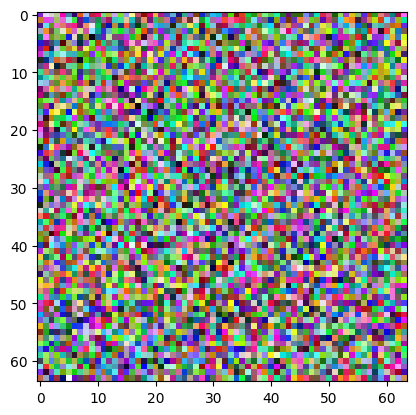

In [20]:
import matplotlib.pyplot as plt

plt.imshow(transforms.ToPILImage()(DeTransformations(image).squeeze(0)))